In [30]:
import os, glob, time, re, json, random
import cv2
import matplotlib.pyplot as plt

class LabeledCsv: # downstream # real data number = frames # active cycle must have trainCsvPathL and valCsvPath !!!
    def __init__(self, imgFolderL, outputFolder, classL, trainCsvPathL=[], txtPathL=[], valCsvPath=None):
        """
        + imgFolderL: folderL have all imgs
        + 2 types of sources
            + trainCsvPathL: inherit previous csvs
            + txtPathL: label videos txts
        + valCsvPath: copy it if specified else cut 20% from dataL as val.csv 
        """
        # hyperparameters
        self.fps, self.frameFreq, self.framesPerStack, self.divide, posThreshold, negThreshold = 30, 4, 16, 5, 0.75, 0.0
        self.posOverlap, self.negOverlap = round(self.framesPerStack*(1-posThreshold)), round(self.framesPerStack*negThreshold) # 4, 0
        # args
        self.imgPathL     = [] # idx2path
        for imgFolder in imgFolderL:
            self.imgPathL += sorted(glob.glob(f"{os.path.abspath(imgFolder)}/*.jpg"))
        self.imgPathD     = dict( zip( self.imgPathL,range(len(self.imgPathL)) ) ) # path2idx
        os.makedirs(outputFolder, exist_ok=True)
        self.outputFolder = outputFolder
        self.classL       = classL
        self.trainCsvPathL= trainCsvPathL
        self.txtPathL     = txtPathL
        self.valCsvPath   = valCsvPath
    
    def cut(self):
        # collect
        dataL = [ line for csvPath in self.trainCsvPathL for line in open(csvPath,"r").readlines() ] # trainCsvPathL
        path  = os.path.abspath( obj.imgPathL[0] + "/../../"  ) # '/home/jovyan/data-vol-1/VideoMAE/_data/imgs'
        for txtPath in self.txtPathL: # txtPathL 
            for line in open(txtPath,"r").readlines():
                line = line.replace("\n","").replace(" ","")
                if "[" in line:
                    videoName = line[1:-1]
                    prevEnd = "" # path of end of previous slot
                else:
                    for cid,timeSlot in enumerate( line.split(",") ):
                        if timeSlot in ['','-'*23]:
                            continue
                        start, end = timeSlot.split("-") # timeString
                        (sh,sm,ss), (eh,em,es) = start.split(":"), end.split(":")
                        start, end = (int(sh)*3600+int(sm)*60+float(ss))*self.fps, (int(eh)*3600+int(em)*60+float(es))*self.fps # timeFloat
                        start = start//self.frameFreq*self.frameFreq + (start%self.frameFreq>=self.frameFreq/2)*self.frameFreq  # frameIdxInt
                        end   =   end//self.frameFreq*self.frameFreq + (  end%self.frameFreq>=self.frameFreq/2)*self.frameFreq
                        start = '0'*(5-len(str(int(start)))) + str(int(start)) # frameIdxString
                        end   = '0'*(5-len(str(int(end  )))) + str(int(end  ))
                        start = f"{path}/{videoName[6:14]}/{videoName.replace('.mp4','_'+start+'.jpg')}" # framePath
                        end   = f"{path}/{videoName[6:14]}/{videoName.replace('.mp4','_'+end  +'.jpg')}"
                        # positive
                        R = list(range(self.imgPathD[start]-self.posOverlap, self.imgPathD[end]-self.framesPerStack+self.posOverlap+1))
                        random.shuffle(R)
                        for idx in R[:self.divide]:
                            dataL.append(f"{self.imgPathL[idx]} {cid}\n")
                        # negative
                        if prevEnd:
                            R = list(range(self.imgPathD[prevEnd]-self.negOverlap, self.imgPathD[start]+self.negOverlap))
                            random.shuffle(R)
                            for idx in R[:self.divide]:
                                dataL.append(f"{self.imgPathL[idx]} {len(self.classL)}\n")
                        prevEnd = end
        # save
        random.shuffle(dataL)
        if self.valCsvPath:
            with open(f"{self.outputFolder}/train.csv","w") as f:
                for data in dataL:
                    f.write(data)
            os.system(f"cp {self.valCsvPath} {self.outputFolder}/val.csv")
            os.system(f"cp {self.valCsvPath} {self.outputFolder}/test.csv")
        else:
            with open(f"{self.outputFolder}/train.csv", "w") as f:
                for data in dataL[:int(len(dataL)*0.8)]:  
                    f.write(data)
            with open(f"{self.outputFolder}/val.csv", "w") as f:
                for data in dataL[int(len(dataL)*0.8):]:                  
                    f.write(data)
            os.system(f"cp {self.outputFolder}/val.csv {self.outputFolder}/test.csv")
        print( "data in [train.csv, val.csv, test.csv] =", [ len(open(f"{self.outputFolder}/{set1}.csv","r").readlines()) for set1 in ("train","val","test") ]  )

    def vis(self, num=1):
        lineL = open(f"{self.outputFolder}/train.csv", "r").readlines()
        R = list(range(len(lineL)))
        random.shuffle(R)
        for i in range(num):
            imgPath, cid = lineL[R[i]][:-1].split(" ")
            startIdx = self.imgPathD[imgPath]
            print(imgPath, cid, startIdx)
            plt.figure(figsize=(6*5,4*4))
            for j in range(4):
                for k in range(self.framesPerStack//4):
                    idx = j*self.framesPerStack//4+k
                    #print( self.imgPathL[startIdx+idx] )
                    plt.subplot(4,self.framesPerStack//4,1+idx)
                    plt.imshow( cv2.imread(self.imgPathL[startIdx+idx])[:,:,::-1] )
                    plt.axis('off')
            plt.show()
            
    def getClassCounts(self):
        for mode in ["train","val"]:
            countClassL = [0]*(len(self.classL)+1)
            for line in open(f"{self.outputFolder}/{mode}.csv", "r").readlines():
                imgPath, cid = line.split(" ")
                countClassL[int(cid)]+=1
            print(f"{mode} - countClassL={countClassL}")

/home/jovyan/data-vol-1/VideoMAE/_data/imgs/20220826/video_20220826001221_03032.jpg 3 5217


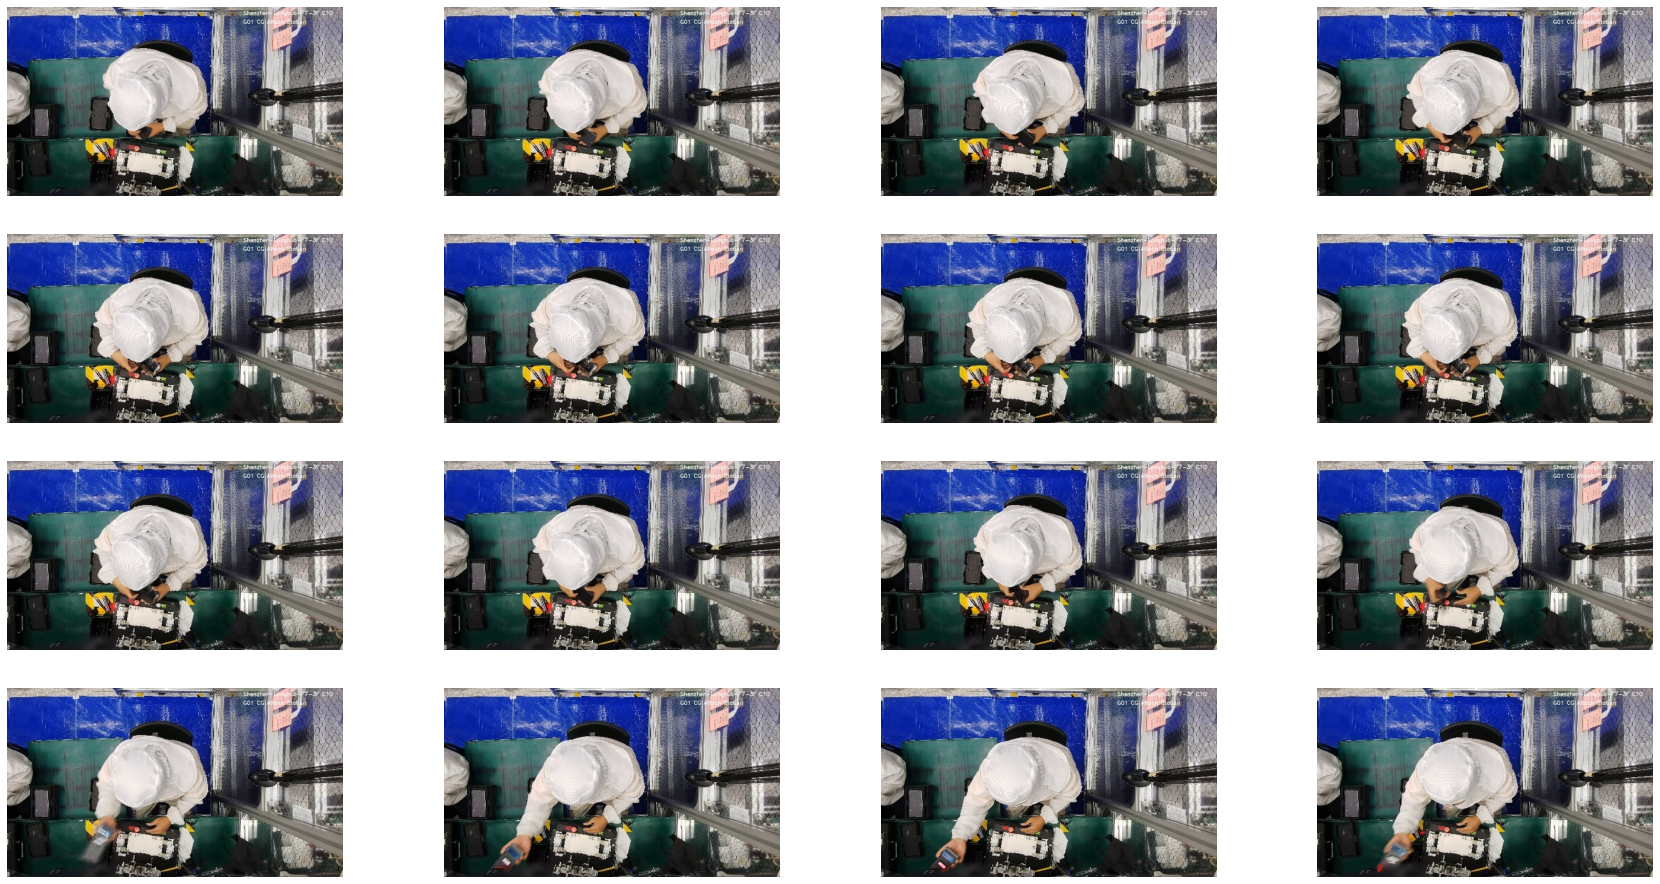

train - countClassL=[125, 118, 116, 341]
val - countClassL=[30, 32, 29, 84]


In [32]:
obj = LabeledCsv(imgFolderL=["../_data/imgs/20220826"], outputFolder="../_data/csvDownstream/20220826_v1", classL=['open','tear','close'], \
                 trainCsvPathL=[], txtPathL=["../_data/labels/labelv1.txt"], valCsvPath=None)
obj.cut()
obj.vis(1)
obj.getClassCounts()